In [27]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl
from tabulate import tabulate
from helpers.util_functions import normalise_value

from moral.ppo import PPO, TrajectoryDataset, update_policy
from envs.gym_wrapper import *
import random

from quality_metrics.validity_measures import validity_all as validity
from quality_metrics.validity_measures import validity_single, validity_single_partial
from quality_metrics.distance_measures import distance_all as distance
from quality_metrics.distance_measures import distance_single
from quality_metrics.diversity_measures import diversity_all as diversity
from quality_metrics.diversity_measures import diversity_single, distance_subtrajectories
from quality_metrics.critical_state_measures import critical_state_all as critical_state
from quality_metrics.critical_state_measures import critical_state_single
from quality_metrics.realisticness_measures import realisticness_all as realisticness
from quality_metrics.realisticness_measures import realisticness_single_partial
from quality_metrics.sparsity_measure import sparsity_all as sparsity
from quality_metrics.sparsity_measure import sparsitiy_single_partial

# pearson correlation
from scipy.stats import pearsonr, spearmanr

In [28]:
class config:
    env_id= 'randomized_v2'
    env_steps= 8e6
    batchsize_ppo= 12
    n_queries= 50
    preference_noise= 0
    n_workers= 1
    lr_ppo= 3e-4
    entropy_reg= 0.25
    gamma= 0.999
    epsilon= 0.1
    ppo_epochs= 5
    max_dacs = 75
    base_path = '.\datasets\\100mdac\\'
    measure_statistics = True
    num_runs = 30
    criteria = ['validity', 'diversity', 'proximity', 'critical_state', 'realisticness', 'sparsity']
    # criteria = ['baseline']
    # criteria = ['validity']
    cf_method = 'mcts' # 'mcts' or 'dac'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [29]:
class config:
    env_id= 'randomized_v2'
    env_steps= 8e6
    batchsize_ppo= 12
    n_queries= 50
    preference_noise= 0
    n_workers= 1
    lr_ppo= 3e-4
    entropy_reg= 0.25
    gamma= 0.999
    epsilon= 0.1
    ppo_epochs= 5
    max_dacs = 75
    base_path = '.\datasets\\100mdac\\'
    measure_statistics = True
    num_runs = 30
    criteria = ['validity', 'diversity', 'proximity', 'critical_state', 'realisticness', 'sparsity']
    # criteria = ['baseline']
    # criteria = ['validity']
    cf_method = 'mcts' # 'mcts' or 'dac'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
class NN_params:
    learning_rate = 0.03
    regularisation = 0.001
    num_layers = 5
    hidden_layer_sizes = [92, 92, 46]
    epochs = 15569

In [31]:
def load_nn_model(num_features, hidden_layer_sizes, num_layers, path, outputs):
    layers = [num_features*2] + hidden_layer_sizes + [outputs]
    base_model = torch.nn.Sequential()
    base_model.add_module('linear' + str(0), torch.nn.Linear(layers[0], layers[1]))
    for i in range(1, num_layers-2):
        base_model.add_module('relu' + str(i-1), torch.nn.ReLU())
        base_model.add_module('linear' + str(i), torch.nn.Linear(layers[i], layers[i+1]))
    base_model.add_module('relu' + str(num_layers-3), torch.nn.ReLU())
    model_end = torch.nn.Linear(layers[-2], layers[-1])

    model = torch.nn.Sequential(base_model, model_end)
    model.load_state_dict(torch.load(path))
    return model

In [36]:
num_features = 46

# numbers from 0 to 29
weights = [i for i in range(1,10)]
weights = ['1.0\\1.0', '2.0\\1.0', '3.0\\1.0', '4.0\\1.0', '5.0\\1.0', '6.0\\1.0', '7.0\\1.0', '8.0\\1.0', '1.0\\2.0', '1.0\\3.0', '1.0\\4.0', '1.0\\5.0', '1.0\\6.0', '1.0\\7.0', '1.0\\8.0', '1.0\\10.0' ,'1.0\\12.0', '1.0\\14.0' ,'1.0\\16.0' ,'1.0\\18.0', '1.0\\20.0' ,'1.0\\25.0' ,'1.0\\30.0' ,'1.0\\35.0' ,'1.0\\40.0', '1.0\\45.0', '1.0\\50.0']

models_con = {}
models_sin = {}

# go through folders in 'datasets\weights\step'
for weight in weights:
    models_con[weight] = []
    models_sin[weight] = []
    folder_path = '..\..\datasets\\ablations_norm\\task_weights2\\' + weight + '\\saved_models'
    for path in os.listdir(folder_path):
        if 'con' in path:
            model = load_nn_model(num_features, NN_params.hidden_layer_sizes, NN_params.num_layers, os.path.join(folder_path, path), 1)
            models_con[weight].append(model)
        elif 'sin' in path:
            model = load_nn_model(num_features, NN_params.hidden_layer_sizes, NN_params.num_layers, os.path.join(folder_path, path), 2)
            models_sin[weight].append(model)

In [37]:
# load the datasets
test_set_cons = {}
test_set_sins = {}
test_labels_cons = {}
test_labels_sins = {}

for weight in weights:
    # datasets\weights\step\weight_1\data_split_con.pkl
    with open('..\..\datasets\\ablations_norm\\best\\mcts\data_split_con.pkl', 'rb') as f:
        _, _, test_set_con, test_labels_con = pkl.load(f)
    with open('..\..\datasets\\ablations_norm\\best\\mcts\data_split_sin.pkl', 'rb') as f:
        _, _, test_set_sin, test_labels_sin = pkl.load(f)

    test_set_cons[weight] = test_set_con
    test_set_sins[weight] = test_set_sin
    test_labels_cons[weight] = test_labels_con
    test_labels_sins[weight] = test_labels_sin

# load the whole test set
with open('..\..\datasets\\ablations_norm\\best\\baseline\data_split_con.pkl', 'rb') as f:
    _, _, test_set_con_combined, test_labels_con_combined = pkl.load(f)
with open('..\..\datasets\\ablations_norm\\best\\baseline\data_split_sin.pkl', 'rb') as f:
    _, _, test_set_sin_combined, test_labels_sin_combined = pkl.load(f)

In [38]:
from evaluation.evaluate_mimic import evaluate_mimic

def test(models, test, labels):
    test_losses_random, test_mean_errors_random, test_rmses_random, r2s_random, pearson_correlations_random, spearman_correlations_random = [], [], [], [], [], []
    for model in models:
        test_loss, test_mean_error, test_rmse, r2, pearson_correlation, spearman_correlation, pred_label_pairs = evaluate_mimic(model, test, labels, worst=False, best=False, features=['citizens_saved', 'unsaved_citizens', 'distance_to_citizen', 'standing_on_extinguisher', 'length', 'could_have_saved', 'final_number_of_unsaved_citizens', 'moved_towards_closest_citizen'])
        test_losses_random.append(test_loss)
        test_mean_errors_random.append(test_mean_error)
        test_rmses_random.append(test_rmse)
        r2s_random.append(r2)
        pearson_correlations_random.append(pearson_correlation)
        spearman_correlations_random.append(spearman_correlation)

    return test_losses_random, test_mean_errors_random, test_rmses_random, r2s_random, pearson_correlations_random, spearman_correlations_random

In [39]:
test_losses_own_con, test_mean_errors_own_con, test_rmses_own_con, r2s_own_con, pearson_correlations_own_con, spearman_correlations_own_con = {}, {}, {}, {}, {}, {}
test_losses_combined_con, test_mean_errors_combined_con, test_rmses_combined_con, r2s_combined_con, pearson_correlations_combined_con, spearman_correlations_combined_con = {}, {}, {}, {}, {}, {}
test_losses_own_sin, test_mean_errors_own_sin, test_rmses_own_sin, r2s_own_sin, pearson_correlations_own_sin, spearman_correlations_own_sin = {}, {}, {}, {}, {}, {}
test_losses_combined_sin, test_mean_errors_combined_sin, test_rmses_combined_sin, r2s_combined_sin, pearson_correlations_combined_sin, spearman_correlations_combined_sin = {}, {}, {}, {}, {}, {}
pearson_correlations_combined_sincon = {}
for weight in weights:
    test_losses_own_con[weight], test_mean_errors_own_con[weight], test_rmses_own_con[weight], r2s_own_con[weight], pearson_correlations_own_con[weight], spearman_correlations_own_con[weight] = test(models_con[weight], test_set_cons[weight], test_labels_cons[weight])
    test_losses_combined_con[weight], test_mean_errors_combined_con[weight], test_rmses_combined_con[weight], r2s_combined_con[weight], pearson_correlations_combined_con[weight], spearman_correlations_combined_con[weight] = test(models_con[weight], test_set_con_combined, test_labels_con_combined)
    test_losses_own_sin[weight], test_mean_errors_own_sin[weight], test_rmses_own_sin[weight], r2s_own_sin[weight], pearson_correlations_own_sin[weight], spearman_correlations_own_sin[weight] = test(models_sin[weight], test_set_sins[weight], test_labels_sins[weight])
    test_losses_combined_sin[weight], test_mean_errors_combined_sin[weight], test_rmses_combined_sin[weight], r2s_combined_sin[weight], pearson_correlations_combined_sin[weight], spearman_correlations_combined_sin[weight] = test(models_sin[weight], test_set_sin_combined, test_labels_sin_combined)

    pearson_correlations_combined_sincon[weight] = [(pearson_correlations_combined_con[weight][i] + pearson_correlations_combined_sin[weight][i])/2 for i in range(len(pearson_correlations_combined_con[weight]))]

c:\Users\janwe\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\janwe\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [22]:
table = [
    ['contrastive:single', 'contrastive', 'single'],
    ['1/8', round(np.mean(pearson_correlations_combined_con['8.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['8.0\\1.0']),2)],
    ['1/7', round(np.mean(pearson_correlations_combined_con['7.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['7.0\\1.0']),2)],
    ['1/6', round(np.mean(pearson_correlations_combined_con['6.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['6.0\\1.0']),2)],
    ['1/5', round(np.mean(pearson_correlations_combined_con['5.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['5.0\\1.0']),2)],
    ['1/4', round(np.mean(pearson_correlations_combined_con['4.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['4.0\\1.0']),2)],
    ['1/3', round(np.mean(pearson_correlations_combined_con['3.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['3.0\\1.0']),2)],
    ['1/2', round(np.mean(pearson_correlations_combined_con['2.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['2.0\\1.0']),2)],
    ['1', round(np.mean(pearson_correlations_combined_con['1.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\1.0']),2)],
    ['2', round(np.mean(pearson_correlations_combined_con['1.0\\2.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\2.0']),2)],
    ['3', round(np.mean(pearson_correlations_combined_con['1.0\\3.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\3.0']),2)],
    ['4', round(np.mean(pearson_correlations_combined_con['1.0\\4.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\4.0']),2)],
    ['5', round(np.mean(pearson_correlations_combined_con['1.0\\5.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\5.0']),2)],
    ['6', round(np.mean(pearson_correlations_combined_con['1.0\\6.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\6.0']),2)],
    ['7', round(np.mean(pearson_correlations_combined_con['1.0\\7.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\7.0']),2)],
    ['8', round(np.mean(pearson_correlations_combined_con['1.0\\8.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\8.0']),2)],
]

print(tabulate(table, headers='firstrow', tablefmt='latex'))

\begin{tabular}{lrr}
\hline
 contrastive:single   &   contrastive &   single \\
\hline
 1/8                  &          0.56 &     0.53 \\
 1/7                  &          0.57 &     0.57 \\
 1/6                  &          0.6  &     0.61 \\
 1/5                  &          0.58 &     0.57 \\
 1/4                  &          0.57 &     0.57 \\
 1/3                  &          0.6  &     0.6  \\
 1/2                  &          0.59 &     0.58 \\
 1                    &          0.58 &     0.58 \\
 2                    &          0.52 &     0.58 \\
 3                    &          0.58 &     0.58 \\
 4                    &          0.58 &     0.58 \\
 5                    &          0.57 &     0.59 \\
 6                    &          0.59 &     0.59 \\
 7                    &          0.6  &     0.6  \\
 8                    &          0.58 &     0.6  \\
\hline
\end{tabular}


In [26]:
table = [
    ['contrastive:single', 'contrastive', 'single'],
    ['8:1', round(np.mean(pearson_correlations_own_con['8.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['8.0\\1.0']),2)],
    ['7:1', round(np.mean(pearson_correlations_own_con['7.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['7.0\\1.0']),2)],
    ['6:1', round(np.mean(pearson_correlations_own_con['6.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['6.0\\1.0']),2)],
    ['5:1', round(np.mean(pearson_correlations_own_con['5.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['5.0\\1.0']),2)],
    ['4:1', round(np.mean(pearson_correlations_own_con['4.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['4.0\\1.0']),2)],
    ['3:1', round(np.mean(pearson_correlations_own_con['3.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['3.0\\1.0']),2)],
    ['2:1', round(np.mean(pearson_correlations_own_con['2.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['2.0\\1.0']),2)],
    ['1:1', round(np.mean(pearson_correlations_own_con['1.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\1.0']),2)],
    ['1:2', round(np.mean(pearson_correlations_own_con['1.0\\2.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\2.0']),2)],
    ['1:3', round(np.mean(pearson_correlations_own_con['1.0\\3.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\3.0']),2)],
    ['1:4', round(np.mean(pearson_correlations_own_con['1.0\\4.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\4.0']),2)],
    ['1:5', round(np.mean(pearson_correlations_own_con['1.0\\5.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\5.0']),2)],
    ['1:6', round(np.mean(pearson_correlations_own_con['1.0\\6.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\6.0']),2)],
    ['1:7', round(np.mean(pearson_correlations_own_con['1.0\\7.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\7.0']),2)],
    ['1:8', round(np.mean(pearson_correlations_own_con['1.0\\8.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\8.0']),2)],
]

print(tabulate(table, headers='firstrow', tablefmt='fancy-grid'))

contrastive:single      contrastive    single
--------------------  -------------  --------
8:1                            0.93      0.86
7:1                            0.96      0.93
6:1                            0.96      0.94
5:1                            0.96      0.93
4:1                            0.93      0.9
3:1                            0.96      0.95
2:1                            0.96      0.94
1:1                            0.96      0.94
1:2                            0.85      0.89
1:3                            0.96      0.93
1:4                            0.94      0.92
1:5                            0.95      0.92
1:6                            0.96      0.94
1:7                            0.96      0.95
1:8                            0.96      0.94


In [42]:
table = [
    ['contrastive:single', 'contrastive own', 'contastive combined', 'single own', 'single combined'],
    ['1/8', round(np.mean(test_losses_own_con['8.0\\1.0']),2), round(np.mean(test_losses_combined_con['8.0\\1.0']),2), round(np.mean(test_losses_own_sin['8.0\\1.0']),2), round(np.mean(test_losses_combined_sin['8.0\\1.0']),2)],
    ['1/7', round(np.mean(test_losses_own_con['7.0\\1.0']),2), round(np.mean(test_losses_combined_con['7.0\\1.0']),2), round(np.mean(test_losses_own_sin['7.0\\1.0']),2), round(np.mean(test_losses_combined_sin['7.0\\1.0']),2)],
    ['1/6', round(np.mean(test_losses_own_con['6.0\\1.0']),2), round(np.mean(test_losses_combined_con['6.0\\1.0']),2), round(np.mean(test_losses_own_sin['6.0\\1.0']),2), round(np.mean(test_losses_combined_sin['6.0\\1.0']),2)],
    ['1/5', round(np.mean(test_losses_own_con['5.0\\1.0']),2), round(np.mean(test_losses_combined_con['5.0\\1.0']),2), round(np.mean(test_losses_own_sin['5.0\\1.0']),2), round(np.mean(test_losses_combined_sin['5.0\\1.0']),2)],
    ['1/4', round(np.mean(test_losses_own_con['4.0\\1.0']),2), round(np.mean(test_losses_combined_con['4.0\\1.0']),2), round(np.mean(test_losses_own_sin['4.0\\1.0']),2), round(np.mean(test_losses_combined_sin['4.0\\1.0']),2)],
    ['1/3', round(np.mean(test_losses_own_con['3.0\\1.0']),2), round(np.mean(test_losses_combined_con['3.0\\1.0']),2), round(np.mean(test_losses_own_sin['3.0\\1.0']),2), round(np.mean(test_losses_combined_sin['3.0\\1.0']),2)],
    ['1/2', round(np.mean(test_losses_own_con['2.0\\1.0']),2), round(np.mean(test_losses_combined_con['2.0\\1.0']),2), round(np.mean(test_losses_own_sin['2.0\\1.0']),2), round(np.mean(test_losses_combined_sin['2.0\\1.0']),2)],
    ['1', round(np.mean(test_losses_own_con['1.0\\1.0']),2), round(np.mean(test_losses_combined_con['1.0\\1.0']),2), round(np.mean(test_losses_own_sin['1.0\\1.0']),2), round(np.mean(test_losses_combined_sin['1.0\\1.0']),2)],
    ['2', round(np.mean(test_losses_own_con['1.0\\2.0']),2), round(np.mean(test_losses_combined_con['1.0\\2.0']),2), round(np.mean(test_losses_own_sin['1.0\\2.0']),2), round(np.mean(test_losses_combined_sin['1.0\\2.0']),2)],
    ['3', round(np.mean(test_losses_own_con['1.0\\3.0']),2), round(np.mean(test_losses_combined_con['1.0\\3.0']),2), round(np.mean(test_losses_own_sin['1.0\\3.0']),2), round(np.mean(test_losses_combined_sin['1.0\\3.0']),2)],
    ['4', round(np.mean(test_losses_own_con['1.0\\4.0']),2), round(np.mean(test_losses_combined_con['1.0\\4.0']),2), round(np.mean(test_losses_own_sin['1.0\\4.0']),2), round(np.mean(test_losses_combined_sin['1.0\\4.0']),2)],
    ['5', round(np.mean(test_losses_own_con['1.0\\5.0']),2), round(np.mean(test_losses_combined_con['1.0\\5.0']),2), round(np.mean(test_losses_own_sin['1.0\\5.0']),2), round(np.mean(test_losses_combined_sin['1.0\\5.0']),2)],
    ['6', round(np.mean(test_losses_own_con['1.0\\6.0']),2), round(np.mean(test_losses_combined_con['1.0\\6.0']),2), round(np.mean(test_losses_own_sin['1.0\\6.0']),2), round(np.mean(test_losses_combined_sin['1.0\\6.0']),2)],
    ['7', round(np.mean(test_losses_own_con['1.0\\7.0']),2), round(np.mean(test_losses_combined_con['1.0\\7.0']),2), round(np.mean(test_losses_own_sin['1.0\\7.0']),2), round(np.mean(test_losses_combined_sin['1.0\\7.0']),2)],
    ['8', round(np.mean(test_losses_own_con['1.0\\8.0']),2), round(np.mean(test_losses_combined_con['1.0\\8.0']),2), round(np.mean(test_losses_own_sin['1.0\\8.0']),2), round(np.mean(test_losses_combined_sin['1.0\\8.0']),2)],
    ['10', round(np.mean(test_losses_own_con['1.0\\10.0']),2), round(np.mean(test_losses_combined_con['1.0\\10.0']),2), round(np.mean(test_losses_own_sin['1.0\\10.0']),2), round(np.mean(test_losses_combined_sin['1.0\\10.0']),2)],
    ['12', round(np.mean(test_losses_own_con['1.0\\12.0']),2), round(np.mean(test_losses_combined_con['1.0\\12.0']),2), round(np.mean(test_losses_own_sin['1.0\\12.0']),2), round(np.mean(test_losses_combined_sin['1.0\\12.0']),2)],
    ['14', round(np.mean(test_losses_own_con['1.0\\14.0']),2), round(np.mean(test_losses_combined_con['1.0\\14.0']),2), round(np.mean(test_losses_own_sin['1.0\\14.0']),2), round(np.mean(test_losses_combined_sin['1.0\\14.0']),2)],
    ['16', round(np.mean(test_losses_own_con['1.0\\16.0']),2), round(np.mean(test_losses_combined_con['1.0\\16.0']),2), round(np.mean(test_losses_own_sin['1.0\\16.0']),2), round(np.mean(test_losses_combined_sin['1.0\\16.0']),2)],
    ['18', round(np.mean(test_losses_own_con['1.0\\18.0']),2), round(np.mean(test_losses_combined_con['1.0\\18.0']),2), round(np.mean(test_losses_own_sin['1.0\\18.0']),2), round(np.mean(test_losses_combined_sin['1.0\\18.0']),2)],
    ['20', round(np.mean(test_losses_own_con['1.0\\20.0']),2), round(np.mean(test_losses_combined_con['1.0\\20.0']),2), round(np.mean(test_losses_own_sin['1.0\\20.0']),2), round(np.mean(test_losses_combined_sin['1.0\\20.0']),2)],
    ['25', round(np.mean(test_losses_own_con['1.0\\25.0']),2), round(np.mean(test_losses_combined_con['1.0\\25.0']),2), round(np.mean(test_losses_own_sin['1.0\\25.0']),2), round(np.mean(test_losses_combined_sin['1.0\\25.0']),2)],
    ['30', round(np.mean(test_losses_own_con['1.0\\30.0']),2), round(np.mean(test_losses_combined_con['1.0\\30.0']),2), round(np.mean(test_losses_own_sin['1.0\\30.0']),2), round(np.mean(test_losses_combined_sin['1.0\\30.0']),2)],
    ['35', round(np.mean(test_losses_own_con['1.0\\35.0']),2), round(np.mean(test_losses_combined_con['1.0\\35.0']),2), round(np.mean(test_losses_own_sin['1.0\\35.0']),2), round(np.mean(test_losses_combined_sin['1.0\\35.0']),2)],
    ['40', round(np.mean(test_losses_own_con['1.0\\40.0']),2), round(np.mean(test_losses_combined_con['1.0\\40.0']),2), round(np.mean(test_losses_own_sin['1.0\\40.0']),2), round(np.mean(test_losses_combined_sin['1.0\\40.0']),2)],
    ['45', round(np.mean(test_losses_own_con['1.0\\45.0']),2), round(np.mean(test_losses_combined_con['1.0\\45.0']),2), round(np.mean(test_losses_own_sin['1.0\\45.0']),2), round(np.mean(test_losses_combined_sin['1.0\\45.0']),2)],
    ['50', round(np.mean(test_losses_own_con['1.0\\50.0']),2), round(np.mean(test_losses_combined_con['1.0\\50.0']),2), round(np.mean(test_losses_own_sin['1.0\\50.0']),2), round(np.mean(test_losses_combined_sin['1.0\\50.0']),2)],
]

print(tabulate(table, headers='firstrow', tablefmt='latex'))   

\begin{tabular}{lrrrr}
\hline
 contrastive:single   &   contrastive own &   contastive combined &   single own &   single combined \\
\hline
 1/8                  &              0.63 &                  2.76 &         2.85 &              7.5  \\
 1/7                  &              0.33 &                  2.85 &         1.44 &              7    \\
 1/6                  &              0.32 &                  2.62 &         1.19 &              6.4  \\
 1/5                  &              0.36 &                  2.78 &         1.38 &              7.27 \\
 1/4                  &              0.6  &                  2.8  &         2.02 &              6.63 \\
 1/3                  &              0.33 &                  2.68 &         1.11 &              6.54 \\
 1/2                  &              0.35 &                  2.72 &         1.32 &              6.91 \\
 1                    &              0.34 &                  2.8  &         1.24 &              6.98 \\
 2                    &    

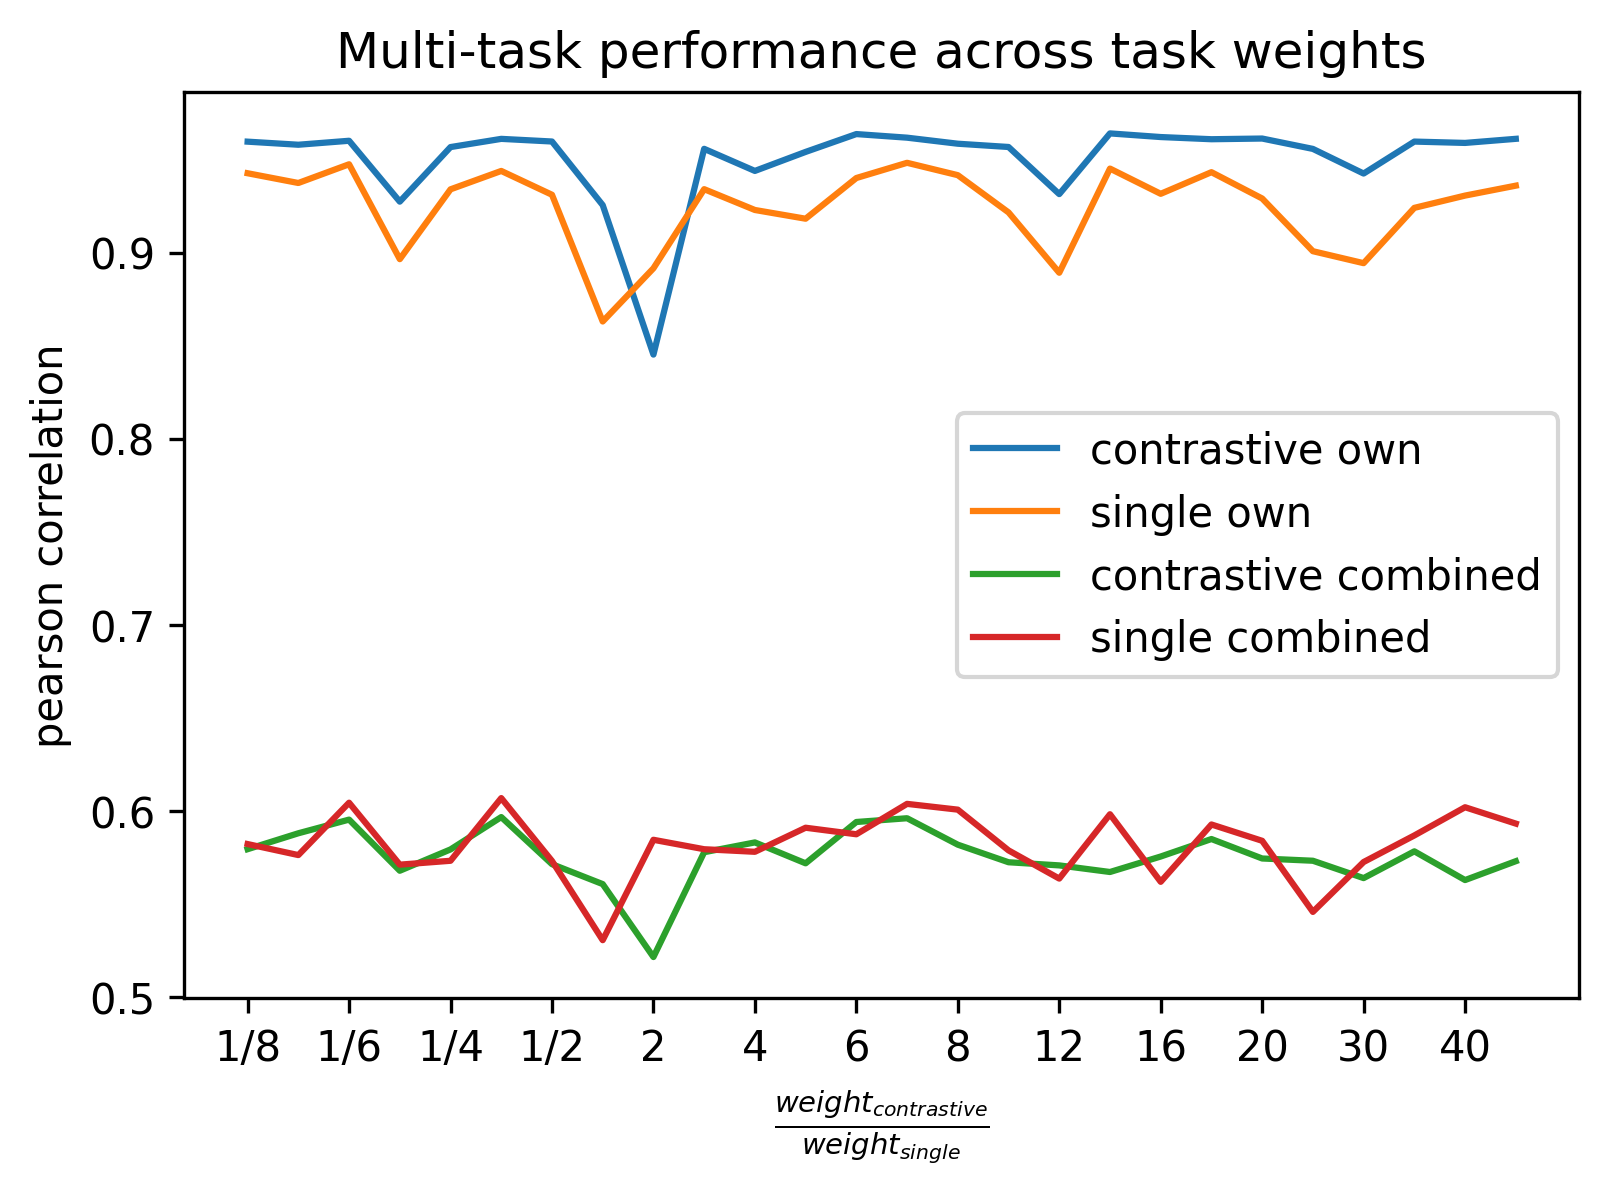

In [64]:
x = ['1/8', '1/7', '1/6', '1/5', '1/4', '1/3', '1/2', 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45]

# plot these 4 lines
fig = plt.figure(dpi=300)

plt.plot(weights, [np.mean(pearson_correlations_own_con[weight]) for weight in weights], label='contrastive own')
plt.plot(weights, [np.mean(pearson_correlations_own_sin[weight]) for weight in weights], label='single own')
plt.plot(weights, [np.mean(pearson_correlations_combined_con[weight]) for weight in weights], label='contrastive combined')
plt.plot(weights, [np.mean(pearson_correlations_combined_sin[weight]) for weight in weights], label='single combined')
plt.legend()
plt.xlabel('$\\frac{weight_{contrastive}}{weight_{single}}$')
plt.xticks(ticks=weights[::2], labels=x[::2])
plt.ylabel('pearson correlation')
plt.title('Multi-task performance across task weights')
# plt.show()
plt.savefig('task_weights.pdf', format='pdf')

In [ ]:
table = [
    ['contrastive:single', 'contrastive own', 'contastive combined', 'single own', 'single combined'],
    ['1/8', round(np.mean(pearson_correlations_own_con['8.0\\1.0']),2), round(np.mean(pearson_correlations_combined_con['8.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['8.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['8.0\\1.0']),2)],
    ['1/7', round(np.mean(pearson_correlations_own_con['7.0\\1.0']),2), round(np.mean(pearson_correlations_combined_con['7.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['7.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['7.0\\1.0']),2)],
    ['1/6', round(np.mean(pearson_correlations_own_con['6.0\\1.0']),2), round(np.mean(pearson_correlations_combined_con['6.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['6.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['6.0\\1.0']),2)],
    ['1/5', round(np.mean(pearson_correlations_own_con['5.0\\1.0']),2), round(np.mean(pearson_correlations_combined_con['5.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['5.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['5.0\\1.0']),2)],
    ['1/4', round(np.mean(pearson_correlations_own_con['4.0\\1.0']),2), round(np.mean(pearson_correlations_combined_con['4.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['4.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['4.0\\1.0']),2)],
    ['1/3', round(np.mean(pearson_correlations_own_con['3.0\\1.0']),2), round(np.mean(pearson_correlations_combined_con['3.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['3.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['3.0\\1.0']),2)],
    ['1/2', round(np.mean(pearson_correlations_own_con['2.0\\1.0']),2), round(np.mean(pearson_correlations_combined_con['2.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['2.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['2.0\\1.0']),2)],
    ['1', round(np.mean(pearson_correlations_own_con['1.0\\1.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\1.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\1.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\1.0']),2)],
    ['2', round(np.mean(pearson_correlations_own_con['1.0\\2.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\2.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\2.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\2.0']),2)],
    ['3', round(np.mean(pearson_correlations_own_con['1.0\\3.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\3.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\3.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\3.0']),2)],
    ['4', round(np.mean(pearson_correlations_own_con['1.0\\4.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\4.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\4.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\4.0']),2)],
    ['5', round(np.mean(pearson_correlations_own_con['1.0\\5.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\5.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\5.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\5.0']),2)],
    ['6', round(np.mean(pearson_correlations_own_con['1.0\\6.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\6.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\6.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\6.0']),2)],
    ['7', round(np.mean(pearson_correlations_own_con['1.0\\7.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\7.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\7.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\7.0']),2)],
    ['8', round(np.mean(pearson_correlations_own_con['1.0\\8.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\8.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\8.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\8.0']),2)],
    ['10', round(np.mean(pearson_correlations_own_con['1.0\\10.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\10.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\10.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\10.0']),2)],
    ['12', round(np.mean(pearson_correlations_own_con['1.0\\12.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\12.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\12.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\12.0']),2)],
    ['14', round(np.mean(pearson_correlations_own_con['1.0\\14.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\14.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\14.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\14.0']),2)],
    ['16', round(np.mean(pearson_correlations_own_con['1.0\\16.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\16.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\16.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\16.0']),2)],
    ['18', round(np.mean(pearson_correlations_own_con['1.0\\18.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\18.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\18.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\18.0']),2)],
    ['20', round(np.mean(pearson_correlations_own_con['1.0\\20.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\20.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\20.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\20.0']),2)],
    ['25', round(np.mean(pearson_correlations_own_con['1.0\\25.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\25.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\25.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\25.0']),2)],
    ['30', round(np.mean(pearson_correlations_own_con['1.0\\30.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\30.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\30.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\30.0']),2)],
    ['35', round(np.mean(pearson_correlations_own_con['1.0\\35.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\35.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\35.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\35.0']),2)],
    ['40', round(np.mean(pearson_correlations_own_con['1.0\\40.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\40.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\40.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\40.0']),2)],
    ['45', round(np.mean(pearson_correlations_own_con['1.0\\45.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\45.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\45.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\45.0']),2)],
    ['50', round(np.mean(pearson_correlations_own_con['1.0\\50.0']),2), round(np.mean(pearson_correlations_combined_con['1.0\\50.0']),2), round(np.mean(pearson_correlations_own_sin['1.0\\50.0']),2), round(np.mean(pearson_correlations_combined_sin['1.0\\50.0']),2)],
]

print(tabulate(table, headers='firstrow', tablefmt='fancy-grid'))   